In [1]:
obj_dims = (648, 486)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers

import os
import json
import scipy.io as sio
from os import path

from src.new_model import *
from src.utils import *
from src.forward_model import *

import PIL
from PIL import Image

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
model_description = 'model-2.12'

In [5]:
real_data_path = path.join('..', 'data', 'real-data', 'realData.mat')
ground_truth_path = path.join('..', 'data', 'real-data', 'beads_GT.png')

real_res_target_path = '../data/real-data/res_target_z1.tif'

# Paths for saving/loading model weights, predictions
base_path = path.join('..', 'models', model_description)
model_weights_path = path.join(base_path, model_description)
image_path = path.join(base_path, 'prediction-images')

In [6]:
comps_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/comps.npy'
weights_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/weights.npy'

# Load in comps and weights
h = np.load(comps_path)
weights = np.load(weights_path)

psf = tf.squeeze(tf.math.reduce_sum(h*weights, axis=0))
psf = psf / tf.math.reduce_max(psf)

In [7]:
# UNet multiwiener
registered_psfs_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/9_psfs/psfs_Z1_1_9_registered.npy'

psfs = np.load(registered_psfs_path).transpose([1, 2, 0])
assert psfs.shape == (648, 486, 9)

Ks = np.ones((1, 1, 9))

In [8]:
# Downsample PSFs for downsampled inputs
psfs = tf.image.resize(psfs, [648//2, 486//2])

In [9]:
# Read in older mat files with scipy.io
data = sio.loadmat(real_data_path)

In [10]:
beads, res = data['beads'], data['resTarget']
beads = np.array(Image.fromarray(beads).resize(obj_dims, resample=PIL.Image.NEAREST))

# Uncomment if downsampling is applied
beads = np.array(tf.squeeze(tf.image.resize(beads[tf.newaxis, ..., tf.newaxis], [486//2, 648//2]))) # Downsample

beads_input_normed = normalize(beads).T
beads_input = beads_input_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

In [11]:
# Load in real res target data
real_res = np.array(Image.open(real_res_target_path).resize(obj_dims, resample=PIL.Image.NEAREST))

# Uncomment if downsampling is applied
real_res = np.array(tf.squeeze(tf.image.resize(real_res[tf.newaxis, ..., tf.newaxis], [486//2, 648//2]))) # Downsample

real_res_normed = normalize(real_res).T
real_res_input = real_res_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

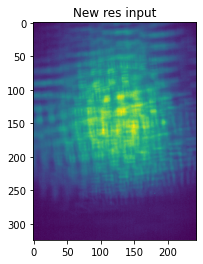

In [12]:
plt.figure()
plt.imshow(real_res_normed)
plt.title('New res input')
plt.show()

In [13]:
# model = UNet_2d()
# model = UNet_2d_wiener(psf, K)
model = UNet_multiwiener_resize(648//2, 486//2, psfs, Ks, 
                         encoding_cs=[24, 64, 128, 256],
                         center_cs=256,
                         decoding_cs=[128, 64, 24, 24],
                         skip_connections=[True, True, True, True])

epoch = 'best'
model.load_weights(model_weights_path + '.{}'.format(epoch))

# Make predictions

In [14]:
pred_beads = model.predict(beads_input).squeeze()
pred_res_real = model.predict(real_res_input).squeeze()

# Visualizations

In [15]:
beads_gt_im = Image.open(ground_truth_path)
beads_gt = np.array(beads_gt_im).T
# Normalize beads from 0 to 1
beads_gt = normalize(beads_gt)

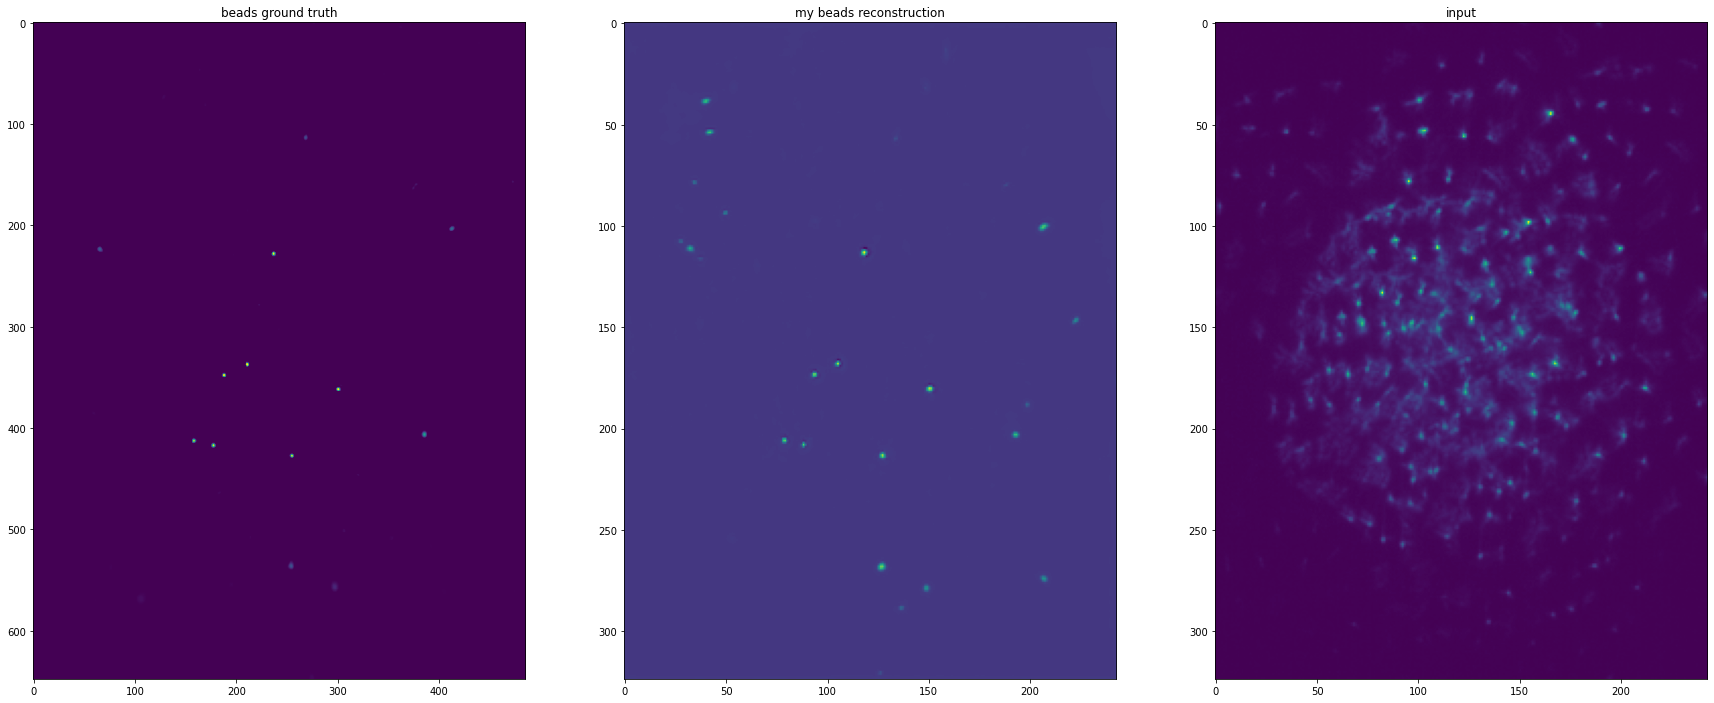

In [17]:
fig = plt.figure(figsize=(30, 30))
f0 = fig.add_subplot(1, 3, 1)
f0.set_title('beads ground truth')
f0.imshow(beads_gt)

f1 = fig.add_subplot(1, 3, 2)
f1.set_title('my beads reconstruction') # Normalized before simulation, but not after
f1.imshow(pred_beads)

f2 = fig.add_subplot(1, 3, 3)
f2.set_title('input')
f2.imshow(beads_input_normed)


# plt.savefig(path.join(image_path, '{}_beads_reconstruction_{}.pdf'.format(model_description, epoch)))
plt.show()

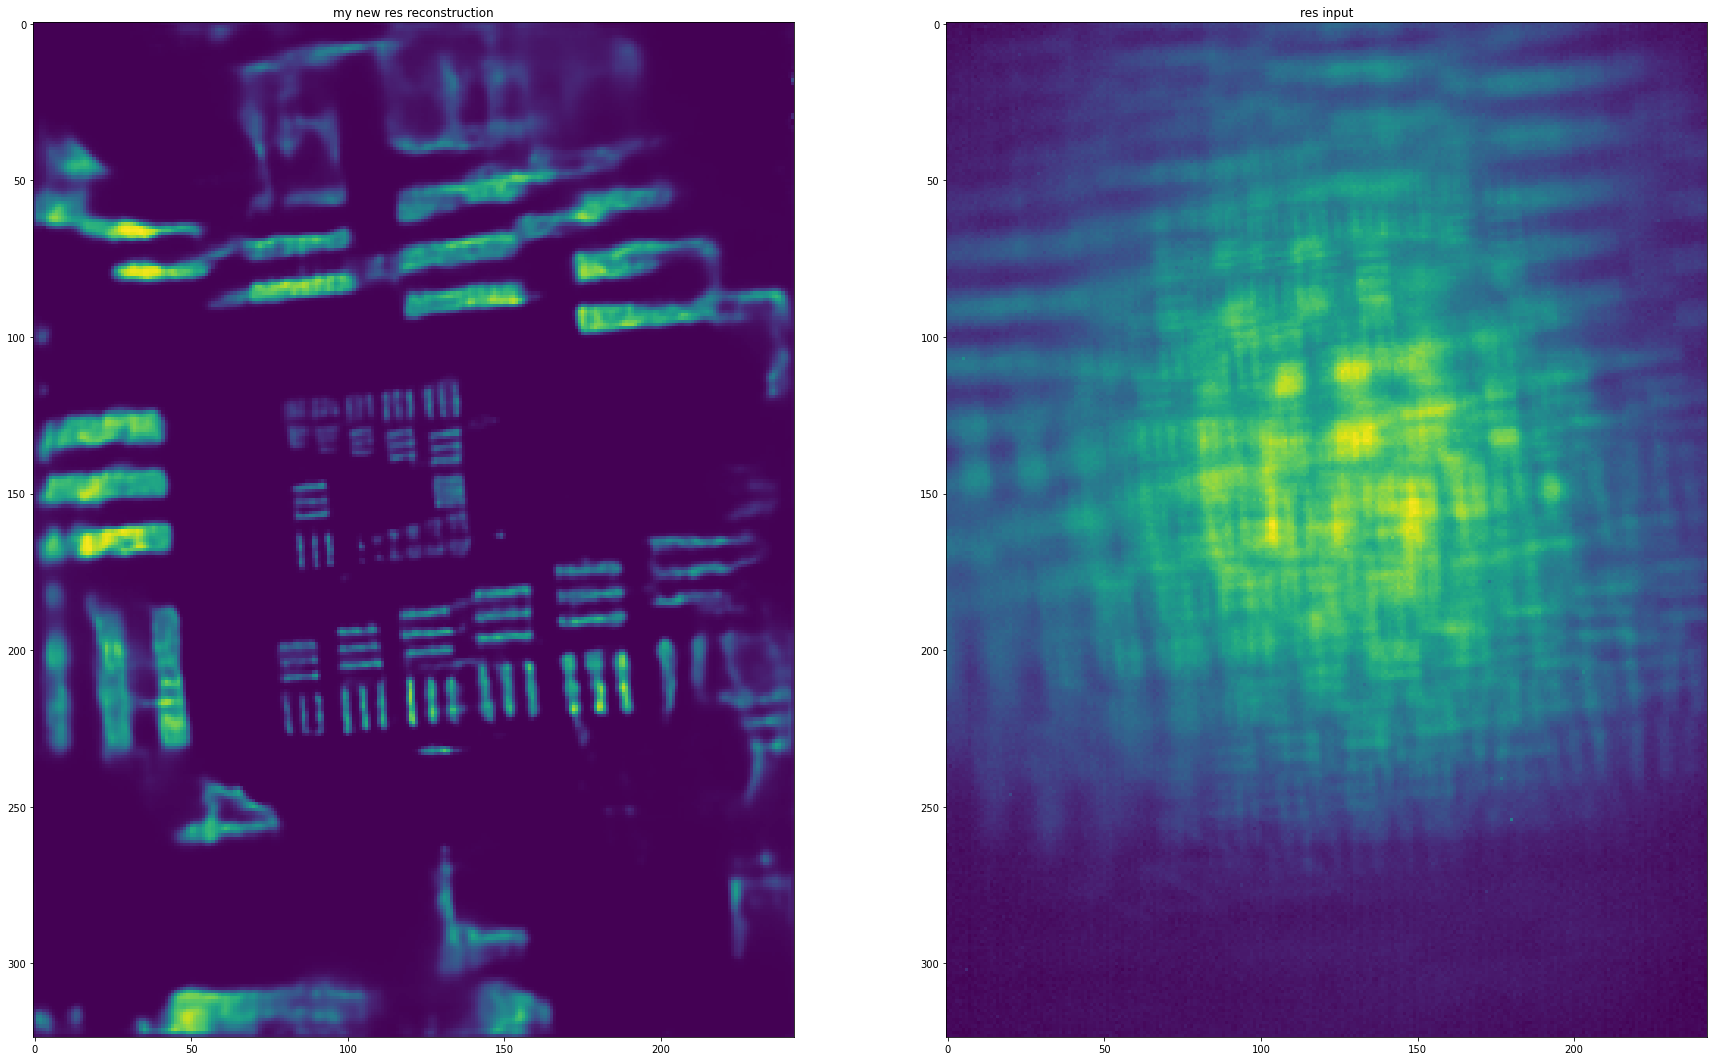

In [19]:
fig = plt.figure(figsize=(30, 30))


f1 = fig.add_subplot(1, 2, 1)
f1.set_title('my new res reconstruction') # Normalized before simulation, but not after
f1.imshow(np.clip(pred_res_real, 0, 1))

f3 = fig.add_subplot(1, 2, 2)
f3.set_title('res input')
f3.imshow(real_res_normed)

# plt.savefig(path.join(image_path, '{}_res_reconstruction_{}.pdf'.format(model_description, epoch)))
plt.show()

# View output of MultiWiener Deconvolution layer

In [28]:
multiwiener_model = tf.keras.Model(model.input, model.get_layer('multi_wiener_deconvolution').output)

In [33]:
wiener_output = multiwiener_model.predict(real_res_input).squeeze()

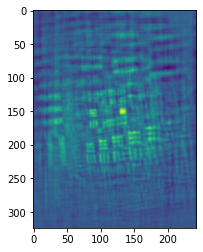

In [44]:
plt.imshow(wiener_output[:, :, 4])